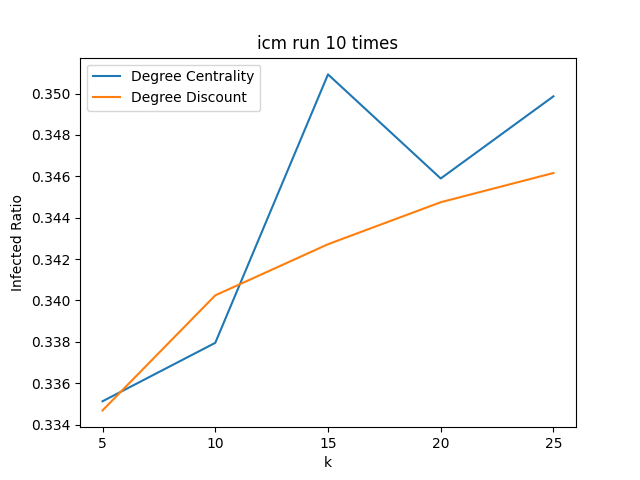

In [3]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib widget    
# 定义度折扣函数
# 使用度折扣算法选择节点，返回被选中的节点集合
# G为NetworkX图对象，k为要选出的节点数，p为节点的传播概率
def degree_discount(G, k, p):
    n = len(G.nodes())  # n为节点数量
    degree = dict(G.degree())  # degree记录每个节点的度数
    dd = degree.copy()  # dd记录每个节点的度折扣值，初始值为节点度数
    t = {node: 0 for node in G.nodes()}  # t记录每个节点在已选节点中的邻居数
    selected_nodes = []  # selected_nodes记录已选节点集合

    for _ in range(k):
        # 选择度折扣最大的节点
        u = max(dd, key=lambda node: dd[node] if node not in selected_nodes else float('-inf'))

        selected_nodes.append(u)  # 将选中的节点加入已选节点集合

        # 更新度折扣
        for v in G.neighbors(u):
            if v not in selected_nodes:
                t[v] += 1
                dd[v] = degree[v] - 2 * t[v] - (degree[v] - t[v]) * t[v] * p

    return selected_nodes  # 返回已选节点集合

# 使用独立级联模型（ICM）模拟节点传播过程，返回所有被激活的节点集合
# G为NetworkX图对象，probabilities为传播概率矩阵，seed_nodes为种子节点集合
def icm(G, probabilities, seed_nodes):
    # 创建一个字典，将图中的节点映射到它们在矩阵中的索引
    dic = dict(zip(G.nodes(), range(len(G.nodes()))))
    newly_activated = set(seed_nodes)  # newly_activated记录新增激活的节点集合，初始值为种子节点集合
    activated_nodes = set(seed_nodes)  # activated_nodes记录所有已经被激活的节点集合
    # print(f"seed_nodes:{seed_nodes}")
    while newly_activated:
        next_activated = set()
        for u in newly_activated:
            # print(f"u:{u}")
            for v in G.neighbors(u):
                # print(f"u:{u},v:{v}")
                if v not in activated_nodes:
                    # print(f"{v} is not in activated_nodes")
                    if random.random() < probabilities[dic.get(u)][dic.get(v)]:  # 根据概率模拟节点激活
                        next_activated.add(v)
                        # print(f"activate {v}")
                        # print(f"next_activated:{next_activated}")
                        activated_nodes.add(v)  # 将新激活的节点添加到已激活节点集合中
                        # print(f"activated_nodes:{activated_nodes}")
                        # print(f"activate {v}")
                        # print(f"activated_nodes:{activated_nodes}")
                    # print(f"{v} is in activated_nodes")
        newly_activated = next_activated
        # print(f"newly_activated:{newly_activated}")
    # print(f"activated_nodes:{activated_nodes}")
    return activated_nodes  # 返回所有被激活的节点集合

# 计算度中心性种子节点
def degree_centrality_seeds(G, k):
    degree = [d[1] for d in G.degree()]
    degree = np.divide(degree , (len(G.nodes()) - 1))
    # print(f"np.argsort(degree)[-k:],{np.argsort(degree)[-k:]}")
    return np.argsort(degree)[-k:]

# 计算感染比例的平均值
def average_infected_ratio(G, probabilities, seeds, runs=10):
    infected_ratios = []
    for i in range(runs):
        activated_nodes = icm(G, probabilities, seeds)
        # print(f"{i}, {activated_nodes}")
        infected_ratios.append(len(activated_nodes) / len(G.nodes()))
    return np.mean(infected_ratios)

# 定义文件路径
file_path = 'email.txt'

# 从文件中读取边列表，创建一个图，其中节点的类型为整数，边的权重为整数
G = nx.read_edgelist(file_path, nodetype=int, data=(('weight', int),), create_using=nx.Graph())
# print(G.degree())
graph = nx.to_numpy_array(G)
# nx.is_connected(G)
# 设置传播概率矩阵
probabilities = np.full(graph.shape, 0.1)
np.fill_diagonal(probabilities, 0)

# 测试不同k值的情况
k_values = [5, 10, 15, 20, 25]
# k_values = [5]
degree_centrality_infected_ratios = []
degree_discount_infected_ratios = []
# 创建一个字典，将图中的节点映射到它们在矩阵中的索引
dic = dict(zip(range(len(G.nodes())),G.nodes()))
# print(f"dic:{dic}")
for k in k_values:
    degree_seeds = degree_centrality_seeds(G, k)
    # print(f"degree_seeds:{degree_seeds}")
    degree_seeds = [dic.get(seed) for seed in degree_seeds]
    # print(f"degree_seeds:{degree_seeds}")
    degree_infected_ratio = average_infected_ratio(G, probabilities, degree_seeds)
    degree_centrality_infected_ratios.append(degree_infected_ratio)

    degree_discount_seeds = degree_discount(G, k, 0.1)
    # print(f"degree_discount_seeds:{degree_discount_seeds}")
    # degree_discount_seeds = [dic.get(seed) for seed in degree_discount_seeds]
    # print(f"degree_discount_seeds:{degree_discount_seeds}")
    degree_discount_infected_ratio = average_infected_ratio(G, probabilities, degree_discount_seeds)
    degree_discount_infected_ratios.append(degree_discount_infected_ratio)
    
# Create a new figure
plt.figure()

# Plot each centrality measure on the same graph
plt.plot(k_values, degree_centrality_infected_ratios, label="Degree Centrality")
plt.plot(k_values, degree_discount_infected_ratios, label="Degree Discount")

# Add labels and legend to the plot
plt.xlabel("k")
plt.xticks(k_values)
plt.ylabel("Infected Ratio")
plt.title("icm run 10 times")
plt.legend()

# Display the plot
plt.show()

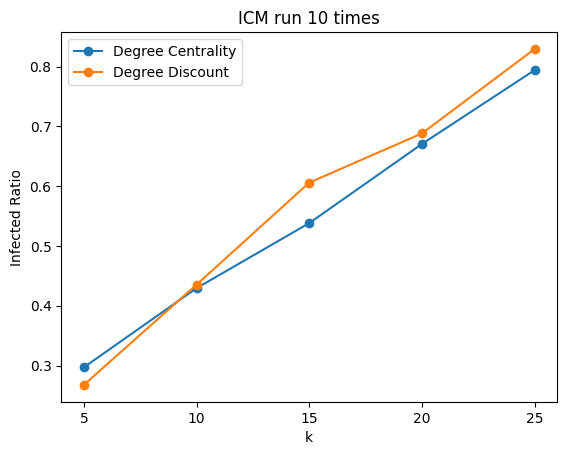

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random

# 定义度折扣函数
def degree_discount(G, k, p):
    n = len(G.nodes())  # n为节点数量
    degree = dict(G.degree())  # degree记录每个节点的度数
    dd = degree.copy()  # dd记录每个节点的度折扣值，初始值为节点度数
    t = {node: 0 for node in G.nodes()}  # t记录每个节点在已选节点中的邻居数
    selected_nodes = []  # selected_nodes记录已选节点集合

    for _ in range(k):
        # 选择度折扣最大的节点
        u = max(dd, key=lambda node: dd[node] if node not in selected_nodes else float('-inf'))
        selected_nodes.append(u)  # 将选中的节点加入已选节点集合

        # 更新度折扣
        for v in G.neighbors(u):
            if v not in selected_nodes:
                t[v] += 1
                dd[v] = degree[v] - 2 * t[v] - (degree[v] - t[v]) * t[v] * p
    return selected_nodes  # 返回已选节点集合

# 使用独立级联模型（ICM）模拟节点传播过程，返回所有被激活的节点集合
def icm(G, probabilities, seed_nodes):
    dic = dict(zip(G.nodes(), range(len(G.nodes()))))  # 创建一个字典，将图中的节点映射到它们在矩阵中的索引
    newly_activated = set(seed_nodes)  # newly_activated记录新增激活的节点集合，初始值为种子节点集合
    activated_nodes = set(seed_nodes)  # activated_nodes记录所有已经被激活的节点集合

    while newly_activated:
        next_activated = set()
        for u in newly_activated:
            for v in G.neighbors(u):
                if v not in activated_nodes:
                    if random.random() < probabilities[dic.get(u)][dic.get(v)]:  # 根据概率模拟节点激活
                        next_activated.add(v)
                        activated_nodes.add(v)  # 将新激活的节点添加到已激活节点集合中
        newly_activated = next_activated
    return activated_nodes  # 返回所有被激活的节点集合

# 计算度中心性种子节点
def degree_centrality_seeds(G, k):
    degree = [d[1] for d in G.degree()]
    degree = np.divide(degree , (len(G.nodes()) - 1))
    return np.argsort(degree)[-k:]

# 计算感染比例的平均值
def average_infected_ratio(G, probabilities, seeds, runs=10):
    infected_ratios = []
    for i in range(runs):
        activated_nodes = icm(G, probabilities, seeds)
        infected_ratios.append(len(activated_nodes) / len(G.nodes()))
    return np.mean(infected_ratios)

# 定义文件路径
file_path = 'karate.txt'

# 从文件中读取边列表，创建一个图，其中节点的类型为整数，边的权重为整数
G = nx.read_edgelist(file_path, nodetype=int, data=(('weight', int),), create_using=nx.Graph())
graph = nx.to_numpy_array(G)
# 设置传播概率矩阵
probabilities = np.full(graph.shape, 0.1)
np.fill_diagonal(probabilities, 0)

# 测试不同k值的情况
k_values = [5, 10, 15, 20, 25]
degree_centrality_infected_ratios = []
degree_discount_infected_ratios = []

# 创建一个字典，将图中的节点映射到它们在矩阵中的索引
dic = dict(zip(range(len(G.nodes())),G.nodes()))

for k in k_values:
    degree_seeds = degree_centrality_seeds(G, k)
    degree_seeds = [dic.get(seed) for seed in degree_seeds]
    degree_infected_ratio = average_infected_ratio(G, probabilities, degree_seeds)
    degree_centrality_infected_ratios.append(degree_infected_ratio)

    degree_discount_seeds = degree_discount(G, k, 0.1)
    degree_discount_infected_ratio = average_infected_ratio(G, probabilities, degree_discount_seeds)
    degree_discount_infected_ratios.append(degree_discount_infected_ratio)

# 创建一个新的图形
plt.figure()

# 在同一张图上绘制每个中心性度量
plt.plot(k_values, degree_centrality_infected_ratios, label="Degree Centrality", marker='o')
plt.plot(k_values, degree_discount_infected_ratios, label="Degree Discount", marker='o')

# 为图形添加标签和图例
plt.xlabel("k") 
plt.xticks(k_values)
plt.ylabel("Infected Ratio")
plt.title("ICM run 10 times")
plt.legend()

# 显示图形
plt.show()


In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib widget    
# 定义度折扣函数
# 使用度折扣算法选择节点，返回被选中的节点集合
# G为NetworkX图对象，k为要选出的节点数，p为节点的传播概率
def degree_discount(G, k, p):
    n = len(G.nodes())  # n为节点数量
    degree = dict(G.degree())  # degree记录每个节点的度数
    dd = degree.copy()  # dd记录每个节点的度折扣值，初始值为节点度数
    t = {node: 0 for node in G.nodes()}  # t记录每个节点在已选节点中的邻居数
    selected_nodes = []  # selected_nodes记录已选节点集合

    for _ in range(k):
        # 选择度折扣最大的节点
        u = max(dd, key=lambda node: dd[node] if node not in selected_nodes else float('-inf'))

        selected_nodes.append(u)  # 将选中的节点加入已选节点集合

        # 更新度折扣
        for v in G.neighbors(u):
            if v not in selected_nodes:
                t[v] += 1
                dd[v] = degree[v] - 2 * t[v] - (degree[v] - t[v]) * t[v] * p

    return selected_nodes  # 返回已选节点集合

# 使用独立级联模型（ICM）模拟节点传播过程，返回所有被激活的节点集合
# G为NetworkX图对象，probabilities为传播概率矩阵，seed_nodes为种子节点集合
def icm(G, probabilities, seed_nodes):
    # 创建一个字典，将图中的节点映射到它们在矩阵中的索引
    dic = dict(zip(G.nodes(), range(len(G.nodes()))))
    newly_activated = set(seed_nodes)  # newly_activated记录新增激活的节点集合，初始值为种子节点集合
    activated_nodes = set(seed_nodes)  # activated_nodes记录所有已经被激活的节点集合
    while newly_activated:
        next_activated = set()
        for u in newly_activated:
            for v in G.neighbors(u):
                if v not in activated_nodes:
                    if random.random() < probabilities[dic.get(u)][dic.get(v)]:  # 根据概率模拟节点激活
                        next_activated.add(v)
                        activated_nodes.add(v)  # 将新激活的节点添加到已激活节点集合中
        newly_activated = next_activated
    return activated_nodes  # 返回所有被激活的节点集合

# 计算度中心性种子节点
def degree_centrality_seeds(G, k):
    degree = [d[1] for d in G.degree()]
    degree = np.divide(degree , (len(G.nodes()) - 1))
    # print(f"np.argsort(degree)[-k:],{np.argsort(degree)[-k:]}")
    return np.argsort(degree)[-k:]

# 计算感染比例的平均值
def average_infected_ratio(G, probabilities, seeds, runs=1000):
    infected_ratios = []
    for i in range(runs):
        activated_nodes = icm(G, probabilities, seeds)
        # print(f"{i}, {activated_nodes}")
        infected_ratios.append(len(activated_nodes) / len(G.nodes()))
    return np.mean(infected_ratios)

# 定义文件路径
file_path = 'email.txt'

# 从文件中读取边列表，创建一个图，其中节点的类型为整数，边的权重为整数
G = nx.read_edgelist(file_path, nodetype=int, data=(('weight', int),), create_using=nx.Graph())
# print(G.degree())
graph = nx.to_numpy_array(G)
# nx.is_connected(G)
# 设置传播概率矩阵
probabilities = np.full(graph.shape, 0.1)
np.fill_diagonal(probabilities, 0)

# 测试不同k值的情况
k_values = [5, 10, 15, 20, 25]
# k_values = [5]
degree_centrality_infected_ratios = []
degree_discount_infected_ratios = []
# 创建一个字典，将图中的节点映射到它们在矩阵中的索引
dic = dict(zip(range(len(G.nodes())),G.nodes()))
# print(f"dic:{dic}")
for k in k_values:
    degree_seeds = degree_centrality_seeds(G, k)
    degree_seeds = [dic.get(seed) for seed in degree_seeds]
    degree_infected_ratio = average_infected_ratio(G, probabilities, degree_seeds)
    degree_centrality_infected_ratios.append(degree_infected_ratio)

    degree_discount_seeds = degree_discount(G, k, 0.1)
    degree_discount_infected_ratio = average_infected_ratio(G, probabilities, degree_discount_seeds)
    degree_discount_infected_ratios.append(degree_discount_infected_ratio)
    
# Create a new figure
plt.figure()

# Plot each centrality measure on the same graph
plt.plot(k_values, degree_centrality_infected_ratios, label="Degree Centrality")
plt.plot(k_values, degree_discount_infected_ratios, label="Degree Discount")

# Add labels and legend to the plot
plt.xlabel("k")
plt.xticks(k_values)
plt.ylabel("Infected Ratio")
plt.title("icm run 1000 times")
plt.legend()

# Display the plot
plt.show()

In [ ]:
# 使用独立级联模型（ICM）模拟节点传播过程，返回所有被激活的节点集合
# # G为NetworkX图对象，probabilities为传播概率矩阵，seed_nodes为种子节点集合
# def icm(G, probabilities, seed_nodes):
#     # 创建一个字典，将图中的节点映射到它们在矩阵中的索引
#     dic = dict(zip(G.nodes(), range(len(G.nodes()))))
#     active_nodes = set(seed_nodes)  # active_nodes记录当前处于激活状态的节点集合
#     newly_activated = set(seed_nodes)  # newly_activated记录新增激活的节点集合，初始值为种子节点集合
#     activated_nodes = set(seed_nodes)  # activated_nodes记录所有已经被激活的节点集合
#     # print(f"seed_nodes:{seed_nodes}")
#     while newly_activated:
#         next_activated = set()
#         for u in newly_activated:
#             for v in G.neighbors(u):
#                 # print(f"u:{u},v:{v}")
#                 if v not in activated_nodes:
#                     if random.random() < probabilities[dic.get(u)][dic.get(v)]:  # 根据概率模拟节点激活
#                         next_activated.add(v)
#                         activated_nodes.add(v)  # 将新激活的节点添加到已激活节点集合中
#                         # print(f"activate {v}")
#                         # print(f"activated_nodes:{activated_nodes}")
#         active_nodes.union(next_activated)  # 将新增激活的节点加入当前激活节点集合
#         newly_activated = next_activated - active_nodes  # 从新增激活节点中去除已经激活的节点
#     # print('activated_nodes')
#     # print(activated_nodes)
#     return active_nodes  # 返回所有被激活的节点集合

In [ ]:
G = nx.karate_club_graph()
%matplotlib inline
pos = nx.circular_layout(G)
nx.draw(G, with_labels=True, font_weight='bold',pos=pos)
import json
G.adj

In [ ]:
lis = [1,2,3,4,5,6,7,8,9,10]
for l in lis:
    if l > 5 and l < 8:
        lis.append(1)
print(lis)

In [ ]:
seed = [11, 13, 26, 14, 32, 20,  4, 30,  9,  7,  6, 17,  5, 19, 31,  8, 12, 29, 16,  3,  1,  2, 21,  0, 23]
set(seed)

In [ ]:
import pdb
a = 1
pdb.set_trace()
b = 2
a,b = b,a
print(a,b)

In [ ]:
# 定义文件路径
file_path = 'karate.txt'

# 从文件中读取边列表，创建一个图，其中节点的类型为整数，边的权重为整数
G = nx.read_edgelist(file_path, nodetype=int, data=(('weight', int),))
print(G.edges())
print(nx.is_directed(G))
print(nx.to_numpy_array(G))

In [ ]:
# 定义文件路径
file_path = 'email.txt'

# 从文件中读取边列表，创建一个图，其中节点的类型为整数，边的权重为整数
G = nx.read_edgelist(file_path)
graph = nx.to_numpy_array(G)
print(graph.shape)

**第一次**
[0.1647058823529412, 0.30882352941176466, 0.47058823529411764, 0.6058823529411764, 0.7529411764705882]

[0.16764705882352943, 0.30000000000000004, 0.4617647058823529, 0.6, 0.7441176470588236]

[0.15294117647058822, 0.31470588235294117, 0.44411764705882356, 0.5970588235294118, 0.7470588235294118]

**第二次**
[0.1676470588235294, 0.3, 0.4617647058823529, 0.6, 0.7558823529411764]

[0.17058823529411765, 0.3088235294117647, 0.45, 0.5970588235294118, 0.7411764705882353]

[0.1588235294117647, 0.31176470588235294, 0.45294117647058824, 0.6088235294117647, 0.7470588235294118]

**第三次**
[0.1558823529411765, 0.3147058823529412, 0.46176470588235297, 0.6058823529411764, 0.7441176470588236]

[0.15588235294117647, 0.31176470588235294, 0.4558823529411765, 0.5970588235294118, 0.7529411764705882]

[0.16176470588235295, 0.32352941176470595, 0.46470588235294114, 0.6029411764705883, 0.7441176470588236]

**run = 100**
[0.16764705882352937, 0.31264705882352944, 0.4594117647058823, 0.6014705882352941, 0.7464705882352941]

[0.16323529411764706, 0.3067647058823529, 0.4573529411764706, 0.6017647058823529, 0.746764705882353]

[0.15999999999999998, 0.3064705882352941, 0.44911764705882345, 0.5994117647058822, 0.7423529411764704]

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
%matplotlib widget    
# 定义度折扣函数
def degree_discount(graph, k, p):
    n = len(graph)
    degree = [sum(row) for row in graph]
    dd = degree.copy()
    t = [0] * n
    selected_nodes = []

    for _ in range(k):
        # 选择度折扣最大的节点
        u = -1
        max_dd = -1
        for v in range(n):
            if v not in selected_nodes and dd[v] > max_dd:
                u = v
                max_dd = dd[v]

        selected_nodes.append(u)

        # 更新度折扣
        for v in range(n):
            if graph[u][v] == 1 and v not in selected_nodes:
                t[v] += 1
                dd[v] = degree[v] - 2 * t[v] - (degree[v] - t[v]) * t[v] * p

    return selected_nodes

def activate_neighbors(graph, probabilities, active_nodes):
    newly_activated = set()
    
    for u in active_nodes:
        for v in range(len(graph[u])):
            if graph[u][v] == 1 and v not in active_nodes:
                if random.random() < probabilities[u][v]:
                    newly_activated.add(v)
    return newly_activated

def icm(graph, probabilities, seed_nodes):
    active_nodes = set(seed_nodes)
    newly_activated = set(seed_nodes)

    while newly_activated:
        newly_activated = activate_neighbors(graph, probabilities, newly_activated)
        active_nodes |= newly_activated

    return active_nodes

# 计算度中心性种子节点
def degree_centrality_seeds(adj, k):
    G = nx.from_numpy_array(adj)
    degree = [d[1] for d in G.degree()]
    degree = np.divide(degree , (len(G.nodes()) - 1))
    return np.argsort(degree)[-k:]

# 计算感染比例的平均值
def average_infected_ratio(graph, probabilities, seeds, runs=10):
    infected_ratios = []
    for _ in range(runs):
        active_nodes = icm(graph, probabilities, seeds)
        infected_ratios.append(len(active_nodes) / len(graph))
    return np.mean(infected_ratios)

# 计算度中心性种子节点
def degree_centrality_seeds(graph, k):
    degree = np.sum(graph, axis=1)
    print(np.argsort(degree)[-k:])
    return np.argsort(degree)[-k:]

# 定义文件路径
file_path = 'email.txt'

# 从文件中读取边列表，创建一个图，其中节点的类型为整数，边的权重为整数
G = nx.read_edgelist(
    file_path,
    nodetype=int,
    data=(('weight', int),)
)

graph = nx.to_numpy_array(G)

# 设置传播概率矩阵
probabilities = np.full(graph.shape, 0.1)
np.fill_diagonal(probabilities, 0)

# 测试不同k值的情况
k_values = [5, 10, 15, 20, 25]
degree_centrality_infected_ratios = []
degree_discount_infected_ratios = []

for k in k_values:
    degree_seeds = degree_centrality_seeds(graph, k)
    degree_infected_ratio = average_infected_ratio(graph, probabilities, degree_seeds)
    degree_centrality_infected_ratios.append(degree_infected_ratio)

    degree_discount_seeds = degree_discount(graph, k, 0.1)
    degree_discount_infected_ratio = average_infected_ratio(graph, probabilities, degree_discount_seeds)
    degree_discount_infected_ratios.append(degree_discount_infected_ratio)

# Create a new figure
plt.figure()

# Plot each centrality measure on the same graph
plt.plot(k_values, degree_centrality_infected_ratios, label="Degree Centrality")
plt.plot(k_values, degree_discount_infected_ratios, label="Degree Discount")

# Add labels and legend to the plot
plt.xlabel("k")
plt.ylabel("Infected Ratio")
plt.legend()

# Display the plot
plt.show()

In [ ]:
# def degree_discount_ic(graph, k, p):
#     S = set()
#     dd = {}
#     t = {}
#     print(graph)
#     # Step 2: Initialize degree discount and t values for each vertex
#     for vertex in graph:
#         degree = len(graph[vertex])
#         dd[vertex] = degree
#         t[vertex] = 0

#     # Step 7: Iterate k times to select k vertices
#     for _ in range(k):
#         # Step 8: Select vertex with maximum degree discount, not in S
#         u = max((vertex for vertex in graph if vertex not in S), key=lambda vertex: dd[vertex])
#         S.add(u)

#         # Step 10: Update degree discount and t values for neighbors of u not in S
#         for neighbor in graph[u]:
#             if neighbor not in S:
#                 t[neighbor] += 1
#                 degree = len(graph[neighbor])
#                 dd[neighbor] = degree - 2 * t[neighbor] - (degree - t[neighbor]) * t[neighbor] * p
                
#     return S

In [ ]:
    
    # degree_seeds = betweenness_centrality_seeds(graph, k)
    # degree_infected_ratio2 = average_infected_ratio(graph, probabilities, degree_seeds)
    # degree_centrality_infected_ratios2.append(degree_infected_ratio2)
        
    # degree_seeds = closeness_centrality_seeds(graph, k)
    # degree_infected_ratio3 = average_infected_ratio(graph, probabilities, degree_seeds)
    # degree_centrality_infected_ratios3.append(degree_infected_ratio3)
    
    # degree_seeds = eigenvector_centrality_seeds(graph, k)
    # degree_infected_ratio4 = average_infected_ratio(graph, probabilities, degree_seeds)
    # degree_centrality_infected_ratios4.append(degree_infected_ratio4)
# plt.plot(k_values, degree_centrality_infected_ratios2, label="Betweenness Centrality")
# plt.plot(k_values, degree_centrality_infected_ratios3, label="Closeness Centrality")
# plt.plot(k_values, degree_centrality_infected_ratios4, label="Eigenvector Centrality")  



In [ ]:
def breadth_first_search(G, source, target=None):
    '''
    输入：

    G：一个图，表示节点及其相互之间的连接关系。在这里，它应该是一个 NetworkX 图对象。
    source：源节点，是 BFS 算法的起点。
    target（可选）：目标节点，如果提供了这个参数，函数将返回源节点到目标节点的最短距离。
    输出：

    如果没有指定目标节点，函数将返回一个字典，键为图中的每个节点，值为一个元组，包含两个元素：该节点到源节点的最短距离和该节点是否已被访问过。
    如果指定了目标节点，函数将返回一个整数，表示源节点到目标节点的最短距离。
    '''
    # 初始化队列，将源节点加入队列
    queue = deque([source])
    # 为图中的每个节点创建一个字典，键为节点，值为一个包含两个元素的元组：距离和是否访问过的布尔值
    node_info = {node: (0, False) for node in G.nodes}
    # 将源节点的距离设置为 0，并将其访问状态设置为 True
    node_info[source] = (0, True)

    # 当队列非空时，继续执行循环
    while queue:
        # 从队列左侧移除并返回一个节点，将其作为当前节点
        current_node = queue.popleft()

        # 如果目标节点不为空，且当前节点等于目标节点，退出循环
        if target is not None and current_node == target:
            break

        # 获取当前节点的相邻节点列表
        neighbors = list(G.neighbors(current_node))
        # 遍历相邻节点
        for neighbor in neighbors:
            # 获取相邻节点的距离和访问状态
            distance, visited = node_info[neighbor]
            # 如果相邻节点未访问过
            if not visited:
                # 更新相邻节点的距离和访问状态
                node_info[neighbor] = (node_info[current_node][0] + 1, True)
                # 将相邻节点添加到队列的右侧
                queue.append(neighbor)

    # 如果没有指定目标节点，返回包含所有节点信息的字典
    if target is None:
        return node_info
    # 如果指定了目标节点，返回目标节点的距离
    else:
        return node_info[target][0]

def bfs(graph, start_node, visited):
    queue = [start_node]
    visited.add(start_node)

    while queue:
        current_node = queue.pop(0)
        for neighbor in graph[current_node]:
            if neighbor not in visited:
                visited.add(neighbor)
                queue.append(neighbor)

def is_connected(G):
    start = next(iter(G.nodes))  # 选择任意一个节点作为起点
    target = None  # 设置目标节点为 None，因为我们只关心访问的节点数量
    node_distances = breadth_first_search(G, start, target)
    
    visited_nodes = [node for node, (distance, visited) in node_distances.items() if visited]
    
    if len(visited_nodes) == len(G.nodes):
        print("Graph is connected")
        return True
    else:
        print("Graph is not connected")
        return False

def get_largest_connected_component(graph):
    visited = set()
    largest_cc = set()
    for node in graph:
        if node not in visited:
            current_cc = set()
            bfs(graph, node, current_cc)
            if len(current_cc) > len(largest_cc):
                largest_cc = current_cc
    return largest_cc
# 幂迭代法计算特征向量中心性
def eigenvector_centrality(adj_matrix, max_iter=100, tol=1e-6):
    if not np.allclose(adj_matrix, adj_matrix.T):
        print("Adjacency matrix is not symmetric.")
    n = adj_matrix.shape[0]
    x = np.random.rand(n, 1)
    x /= np.linalg.norm(x)
    for _ in range(max_iter):
        x_next = adj_matrix @ x
        x_next /= np.linalg.norm(x_next)
        if np.linalg.norm(x_next - x) < tol:
            break
        x = x_next
    return x
    
def Closeness_Centrality(G):
    shoretest_path_matrix = np.zeros((len(G.nodes()), len(G.nodes())))
    dic = dict(zip(G.nodes(), range(len(G.nodes()))))
    for start in G.nodes:
        for end in G.nodes:
            if start != end:
                if shoretest_path_matrix[dic.get(start), dic.get(end)] == 0:
                    shoretest_path_matrix[dic.get(start), dic.get(end)] = breadth_first_search(G, start, end) 
                    continue
    return (len(G.nodes()) - 1) / shoretest_path_matrix.sum(axis = 1)
    

def degree_centralized_distribution(G):
    degree = [d[1] for d in G.degree()]
    plt.bar(G.nodes(), np.divide(degree , (len(G.nodes()) - 1)))
    plt.xlabel('Degree')
    plt.ylabel('Count')
    plt.title('Degree Centralised Distribution')
    plt.show()
    return np.divide(degree , (len(G.nodes()) - 1))

def bfs_shortest_paths(G, source):
    visited = {source: 0}
    queue = [source]
    paths = {node: [] for node in G.nodes}
    paths[source] = [[source]]

    while queue:
        current = queue.pop(0)
        neighbors = G[current]

        for neighbor in neighbors:
            if neighbor not in visited:
                visited[neighbor] = visited[current] + 1
                queue.append(neighbor)

            if visited[neighbor] == visited[current] + 1:
                paths[neighbor] += [path + [neighbor] for path in paths[current]]

    return paths

def betweenness_centrality(G):
    shoretest_path_matrix = shortest_path_number(G)
    dic = dict(zip(G.nodes(), range(len(G.nodes()))))
    Numerator = [np.zeros((len(G.nodes()), len(G.nodes()))) for _ in range(len(G.nodes()))]
    for node in G.nodes:
        for start in [n for n in G.nodes if n != node]:
            for end in [n for n in G.nodes if n != node]:
                if start != end:
                    # Calculate the number of shortest paths from start to end that pass through node
                    shortest_paths = bfs_shortest_paths(G, start)
                    count = sum(node in path for path in shortest_paths[end])
                    Numerator[dic.get(node)][dic.get(start)][dic.get(end)] += count
    
    # 将 shoretest_path_matrix 转换为 NumPy 数组
    shoretest_path_matrix_np = np.array(shoretest_path_matrix)
    # print(Numerator)
    Numerator_np = np.array(Numerator)
    # 然后计算 result
    re = []
    mask = shoretest_path_matrix_np != 0
    # print(mask)
    for i in Numerator_np:
        # 创建一个掩码，标识 B 中非零元素的位置
        # print(i)
        # 初始化一个与 A 相同形状的全零矩阵
        result = np.zeros_like(i)

        # 只对 B 中非零元素对应的位置进行除法操作
        result[mask] = i[mask] / shoretest_path_matrix_np[mask]

        re.append(np.sum(result))
    re = np.array(re)
    # 输出结果
    result = re/((len(G.nodes()) - 1) * (len(G.nodes()) - 2))
    return result
    
def shortest_path_number(G):
    n = G.number_of_nodes()
    matrix = [np.zeros((n, n))]
    shortest_path_number = np.zeros((n, n))
    np.fill_diagonal(shortest_path_number, np.inf)
    adj_matrix = np.array(nx.to_numpy_array(G))
    matrix = adj_matrix
    mask = shortest_path_number != 0
    np.fill_diagonal(shortest_path_number, np.inf)
    for i in range(1, n):
        for p in range(n): 
            for q in range(n):
                if q != p:
                    if matrix[p][q] != 0 and shortest_path_number[p][q] == 0:
                        shortest_path_number[p][q] = matrix[p][q]
        matrix = matrix @ adj_matrix
    # 将对角线上的值设置为0，因为节点到自身的距离为0
    np.fill_diagonal(shortest_path_number, 0)
    return shortest_path_number

In [ ]:
# 计算特征向量中心性种子节点
def betweenness_centrality_seeds(G, k):
    # G = nx.from_numpy_array(adj)
    print(eigenvector_centrality(G))
    # degree = [v for d,v in eigenvector_centrality(G).items()]
    # return np.argsort(degree)[-k:]
G = nx.karate_club_graph()
betweenness_centrality(G)

In [ ]:
def demo():
    global x
    x =3
    y =4
    z =5
    print(x,y,z)
x= 10
z = 20
demo()

# 计算介数中心性种子节点
def betweenness_centrality_seeds(adj, k):
    G = nx.from_numpy_array(adj)
    return np.argsort(betweenness_centrality(G))[-k:]

# 计算特征向量中心性种子节点
def eigenvector_centrality_seeds(adj, k):
    return np.argsort(eigenvector_centrality(adj))[-k:]

# 计算接近中心性种子节点
def closeness_centrality_seeds(adj, k):
    G = nx.from_numpy_array(adj)    
    return np.argsort(Closeness_Centrality(G))[-k:]


In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

def breadth_first_search(G, source, target=None):
    '''
    输入：

    G：一个图，表示节点及其相互之间的连接关系。在这里，它应该是一个 NetworkX 图对象。
    source：源节点，是 BFS 算法的起点。
    target（可选）：目标节点，如果提供了这个参数，函数将返回源节点到目标节点的最短距离。
    输出：

    如果没有指定目标节点，函数将返回一个字典，键为图中的每个节点，值为一个元组，包含两个元素：该节点到源节点的最短距离和该节点是否已被访问过。
    如果指定了目标节点，函数将返回一个整数，表示源节点到目标节点的最短距离。
    '''
    # 初始化队列，将源节点加入队列
    queue = deque([source])
    # 为图中的每个节点创建一个字典，键为节点，值为一个包含两个元素的元组：距离和是否访问过的布尔值
    node_info = {node: (0, False) for node in G.nodes}
    # 将源节点的距离设置为 0，并将其访问状态设置为 True
    node_info[source] = (0, True)

    # 当队列非空时，继续执行循环
    while queue:
        # 从队列左侧移除并返回一个节点，将其作为当前节点
        current_node = queue.popleft()

        # 如果目标节点不为空，且当前节点等于目标节点，退出循环
        if target is not None and current_node == target:
            break

        # 获取当前节点的相邻节点列表
        neighbors = list(G.neighbors(current_node))
        # 遍历相邻节点
        for neighbor in neighbors:
            # 获取相邻节点的距离和访问状态
            distance, visited = node_info[neighbor]
            # 如果相邻节点未访问过
            if not visited:
                # 更新相邻节点的距离和访问状态
                node_info[neighbor] = (node_info[current_node][0] + 1, True)
                # 将相邻节点添加到队列的右侧
                queue.append(neighbor)

    # 如果没有指定目标节点，返回包含所有节点信息的字典
    if target is None:
        return node_info
    # 如果指定了目标节点，返回目标节点的距离
    else:
        return node_info[target][0]

def bfs(graph, start_node, visited):
    queue = [start_node]
    visited.add(start_node)

    while queue:
        current_node = queue.pop(0)
        for neighbor in graph[current_node]:
            if neighbor not in visited:
                visited.add(neighbor)
                queue.append(neighbor)

def is_connected(G):
    start = next(iter(G.nodes))  # 选择任意一个节点作为起点
    target = None  # 设置目标节点为 None，因为我们只关心访问的节点数量
    node_distances = breadth_first_search(G, start, target)
    
    visited_nodes = [node for node, (distance, visited) in node_distances.items() if visited]
    
    if len(visited_nodes) == len(G.nodes):
        print("Graph is connected")
        return True
    else:
        print("Graph is not connected")
        return False

def get_largest_connected_component(graph):
    visited = set()
    largest_cc = set()
    for node in graph:
        if node not in visited:
            current_cc = set()
            bfs(graph, node, current_cc)
            if len(current_cc) > len(largest_cc):
                largest_cc = current_cc
    return largest_cc
# 幂迭代法计算特征向量中心性
def eigenvector_centrality(adj_matrix, max_iter=100, tol=1e-6):
    if not np.allclose(adj_matrix, adj_matrix.T):
        print("Adjacency matrix is not symmetric.")
    n = adj_matrix.shape[0]
    x = np.random.rand(n, 1)
    x /= np.linalg.norm(x)
    for _ in range(max_iter):
        x_next = adj_matrix @ x
        x_next /= np.linalg.norm(x_next)
        if np.linalg.norm(x_next - x) < tol:
            break
        x = x_next
    return x
    
def Closeness_Centrality(G):
    shoretest_path_matrix = np.zeros((len(G.nodes()), len(G.nodes())))
    dic = dict(zip(G.nodes(), range(len(G.nodes()))))
    for start in G.nodes:
        for end in G.nodes:
            if start != end:
                if shoretest_path_matrix[dic.get(start), dic.get(end)] == 0:
                    shoretest_path_matrix[dic.get(start), dic.get(end)] = breadth_first_search(G, start, end) 
                    continue
    print(shoretest_path_matrix)
    return (len(G.nodes()) - 1) / shoretest_path_matrix.sum(axis = 1)
    

def degree_centralized_distribution(G):
    degree = [d[1] for d in G.degree()]
    plt.bar(G.nodes(), np.divide(degree , (len(G.nodes()) - 1)))
    plt.xlabel('Degree')
    plt.ylabel('Count')
    plt.title('Degree Centralised Distribution')
    plt.show()
    return np.divide(degree , (len(G.nodes()) - 1))
# degree_centralized_distribution(G)

def bfs_shortest_paths(G, source):
    visited = {source: 0}
    queue = [source]
    paths = {node: [] for node in G.nodes}
    paths[source] = [[source]]

    while queue:
        current = queue.pop(0)
        neighbors = G[current]

        for neighbor in neighbors:
            if neighbor not in visited:
                visited[neighbor] = visited[current] + 1
                queue.append(neighbor)

            if visited[neighbor] == visited[current] + 1:
                paths[neighbor] += [path + [neighbor] for path in paths[current]]

    return paths

def betweenness_centrality(G):
    shoretest_path_matrix = shortest_path_number(G)
    dic = dict(zip(G.nodes(), range(len(G.nodes()))))
    Numerator = [np.zeros((len(G.nodes()), len(G.nodes()))) for _ in range(len(G.nodes()))]
    for node in G.nodes:
        for start in [n for n in G.nodes if n != node]:
            for end in [n for n in G.nodes if n != node]:
                if start != end:
                    # Calculate the number of shortest paths from start to end that pass through node
                    shortest_paths = bfs_shortest_paths(G, start)
                    count = sum(node in path for path in shortest_paths[end])
                    Numerator[dic.get(node)][dic.get(start)][dic.get(end)] += count
    
    # 将 shoretest_path_matrix 转换为 NumPy 数组
    shoretest_path_matrix_np = np.array(shoretest_path_matrix)
    # print(Numerator)
    Numerator_np = np.array(Numerator)
    # 然后计算 result
    re = []
    mask = shoretest_path_matrix_np != 0
    # print(mask)
    for i in Numerator_np:
        # 创建一个掩码，标识 B 中非零元素的位置
        # print(i)
        # 初始化一个与 A 相同形状的全零矩阵
        result = np.zeros_like(i)

        # 只对 B 中非零元素对应的位置进行除法操作
        result[mask] = i[mask] / shoretest_path_matrix_np[mask]

        re.append(np.sum(result))
    # result = shoretest_path_matrix_np[:, :, np.newaxis] / Numerator
    re = np.array(re)
    
    print("betweenness_centrality NetworkX:", nx.betweenness_centrality(G,normalized=True))
    # 输出结果
    result = dict(zip(G.nodes(), re/((len(G.nodes()) - 1) * (len(G.nodes()) - 2))))
    return result
    
def shortest_path_number(G):
    n = G.number_of_nodes()
    matrix = [np.zeros((n, n))]
    shortest_path_number = np.zeros((n, n))
    np.fill_diagonal(shortest_path_number, np.inf)
    adj_matrix = np.array(nx.to_numpy_array(G))
    matrix = adj_matrix
    mask = shortest_path_number != 0
    np.fill_diagonal(shortest_path_number, np.inf)
    for i in range(1, n):
        for p in range(n): 
            for q in range(n):
                if q != p:
                    if matrix[p][q] != 0 and shortest_path_number[p][q] == 0:
                        shortest_path_number[p][q] = matrix[p][q]
        matrix = matrix @ adj_matrix
        # print(matrix)
    # 将对角线上的值设置为0，因为节点到自身的距离为0
    np.fill_diagonal(shortest_path_number, 0)
    return shortest_path_number
    
def k_shell_decomposition(graph):
    k_shell = {}
    k = 1
    
    while graph.nodes():
        nodes_to_remove = []
        for node in graph.nodes():
            if graph.degree(node) <= k:
                nodes_to_remove.append(node)
                k_shell[node] = k

        if not nodes_to_remove:
            k += 1
        else:
            graph.remove_nodes_from(nodes_to_remove)

    return k_shell

file_path = "karate.txt"
# 从文件中读取边列表，创建一个图，其中节点的类型为整数，边的权重为整数
G = nx.read_edgelist(
    file_path,
    nodetype=int,
    data=(('weight', int),)
)
# nx.draw(G, with_labels=True)
# plt.show()
# 将图转换为 NumPy 矩阵
# adj_matrix = nx.to_numpy_matrix(G)
# print(f"own code degeree contrality: {degree_centralized_distribution(G)}")
# print(f"NetworkX: {nx.degree_centrality(G)}")
# print(f"own code closeness contrality: {Closeness_Centrality(G)}")
# print(f"NetworkX: {nx.closeness_centrality(G)}")
path = [] 

# 计算特征向量中心性
# centrality = nx.eigenvector_centrality(G)

# 判断是否是连通图
# if not is_connected(G):
#     G_set = get_largest_connected_component(G)
#     G_list = list(G_set)
#     # print(f"Largest connected component is {G_list}")
#     for i in list(G.nodes()):
#         if i not in G_list:
#             G.remove_node(i)
# print(f"networkX result based on norm 1:{nx.eigenvector_centrality(G)}")
# print(f"eigenvector_centrality based on norm 2:{eigenvector_centrality(adj_matrix)}")
print(f"Own code:{betweenness_centrality(G)}")
# save_path = "shoretest_path_matrix_sum.txt"
# np.savetxt(save_path, shoretest_path_matrix.sum(axis = 1) / (len(G.nodes()) - 1), fmt = '%f', delimiter = ' ')
# # 输出结果
# print(centrality)
# nodes = [n for n in G.nodes() if n != 27]
# for n in nodes:
#     path.append(breadth_first_search(G, 27, n))
# print(path)
#     path.append(breadth_first_search(G, node))
# dict = zip(G.nodes(), path)
# print(list(dict))
    
# Centrifugal_centrality = []
# for node in G.nodes():
#     nodes = [n for n in G.nodes() if n != node]
#     for n in nodes:
#         path.append(breadth_first_search(G, node, n))
#     Centrifugal_centrality.append(max(path))
#     path = []
# List = zip(G.nodes(), Centrifugal_centrality)
# print(list(List))




    




In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

def breadth_first_search(G, source, target=None):
    '''
    输入：

    G：一个图，表示节点及其相互之间的连接关系。在这里，它应该是一个 NetworkX 图对象。
    source：源节点，是 BFS 算法的起点。
    target（可选）：目标节点，如果提供了这个参数，函数将返回源节点到目标节点的最短距离。
    输出：

    如果没有指定目标节点，函数将返回一个字典，键为图中的每个节点，值为一个元组，包含两个元素：该节点到源节点的最短距离和该节点是否已被访问过。
    如果指定了目标节点，函数将返回一个整数，表示源节点到目标节点的最短距离。
    '''
    # 初始化队列，将源节点加入队列
    queue = deque([source])
    # 为图中的每个节点创建一个字典，键为节点，值为一个包含两个元素的元组：距离和是否访问过的布尔值
    node_info = {node: (0, False) for node in G.nodes}
    # 将源节点的距离设置为 0，并将其访问状态设置为 True
    node_info[source] = (0, True)

    # 当队列非空时，继续执行循环
    while queue:
        # 从队列左侧移除并返回一个节点，将其作为当前节点
        current_node = queue.popleft()

        # 如果目标节点不为空，且当前节点等于目标节点，退出循环
        if target is not None and current_node == target:
            break

        # 获取当前节点的相邻节点列表
        neighbors = list(G.neighbors(current_node))
        # 遍历相邻节点
        for neighbor in neighbors:
            # 获取相邻节点的距离和访问状态
            distance, visited = node_info[neighbor]
            # 如果相邻节点未访问过
            if not visited:
                # 更新相邻节点的距离和访问状态
                node_info[neighbor] = (node_info[current_node][0] + 1, True)
                # 将相邻节点添加到队列的右侧
                queue.append(neighbor)

    # 如果没有指定目标节点，返回包含所有节点信息的字典
    if target is None:
        return node_info
    # 如果指定了目标节点，返回目标节点的距离
    else:
        return node_info[target][0]

def bfs(graph, start_node, visited):
    queue = [start_node]
    visited.add(start_node)

    while queue:
        current_node = queue.pop(0)
        for neighbor in graph[current_node]:
            if neighbor not in visited:
                visited.add(neighbor)
                queue.append(neighbor)

def is_connected(G):
    start = next(iter(G.nodes))  # 选择任意一个节点作为起点
    target = None  # 设置目标节点为 None，因为我们只关心访问的节点数量
    node_distances = breadth_first_search(G, start, target)
    
    visited_nodes = [node for node, (distance, visited) in node_distances.items() if visited]
    
    if len(visited_nodes) == len(G.nodes):
        print("Graph is connected")
        return True
    else:
        print("Graph is not connected")
        return False

def get_largest_connected_component(graph):
    visited = set()
    largest_cc = set()
    for node in graph:
        if node not in visited:
            current_cc = set()
            bfs(graph, node, current_cc)
            if len(current_cc) > len(largest_cc):
                largest_cc = current_cc
    return largest_cc
# 幂迭代法计算特征向量中心性
def eigenvector_centrality(adj_matrix, max_iter=100, tol=1e-6):
    if not np.allclose(adj_matrix, adj_matrix.T):
        print("Adjacency matrix is not symmetric.")
    n = adj_matrix.shape[0]
    x = np.random.rand(n, 1)
    x /= np.linalg.norm(x)
    for _ in range(max_iter):
        x_next = adj_matrix @ x
        x_next /= np.linalg.norm(x_next)
        if np.linalg.norm(x_next - x) < tol:
            break
        x = x_next
    return x
    
def Closeness_Centrality(G):
    shoretest_path_matrix = np.zeros((len(G.nodes()), len(G.nodes())))
    dic = dict(zip(G.nodes(), range(len(G.nodes()))))
    for start in G.nodes:
        for end in G.nodes:
            if start != end:
                if shoretest_path_matrix[dic.get(start), dic.get(end)] == 0:
                    shoretest_path_matrix[dic.get(start), dic.get(end)] = breadth_first_search(G, start, end) 
                    continue
    print(shoretest_path_matrix)
    return (len(G.nodes()) - 1) / shoretest_path_matrix.sum(axis = 1)
    

def degree_centralized_distribution(G):
    degree = [d[1] for d in G.degree()]
    plt.bar(G.nodes(), np.divide(degree , (len(G.nodes()) - 1)))
    plt.xlabel('Degree')
    plt.ylabel('Count')
    plt.title('Degree Centralised Distribution')
    plt.show()
    return np.divide(degree , (len(G.nodes()) - 1))
# degree_centralized_distribution(G)

def bfs_shortest_paths(G, source):
    visited = {source: 0}
    queue = [source]
    paths = {node: [] for node in G.nodes}
    paths[source] = [[source]]

    while queue:
        current = queue.pop(0)
        neighbors = G[current]

        for neighbor in neighbors:
            if neighbor not in visited:
                visited[neighbor] = visited[current] + 1
                queue.append(neighbor)

            if visited[neighbor] == visited[current] + 1:
                paths[neighbor] += [path + [neighbor] for path in paths[current]]

    return paths

def betweenness_centrality(G):
    shoretest_path_matrix = shortest_path_number(G)
    dic = dict(zip(G.nodes(), range(len(G.nodes()))))
    Numerator = [np.zeros((len(G.nodes()), len(G.nodes()))) for _ in range(len(G.nodes()))]
    for node in G.nodes:
        for start in [n for n in G.nodes if n != node]:
            for end in [n for n in G.nodes if n != node]:
                if start != end:
                    # Calculate the number of shortest paths from start to end that pass through node
                    shortest_paths = bfs_shortest_paths(G, start)
                    count = sum(node in path for path in shortest_paths[end])
                    Numerator[dic.get(node)][dic.get(start)][dic.get(end)] += count
    
    # 将 shoretest_path_matrix 转换为 NumPy 数组
    shoretest_path_matrix_np = np.array(shoretest_path_matrix)
    # print(Numerator)
    Numerator_np = np.array(Numerator)
    # 然后计算 result
    re = []
    mask = shoretest_path_matrix_np != 0
    # print(mask)
    for i in Numerator_np:
        # 创建一个掩码，标识 B 中非零元素的位置
        # print(i)
        # 初始化一个与 A 相同形状的全零矩阵
        result = np.zeros_like(i)

        # 只对 B 中非零元素对应的位置进行除法操作
        result[mask] = i[mask] / shoretest_path_matrix_np[mask]

        re.append(np.sum(result))
    # result = shoretest_path_matrix_np[:, :, np.newaxis] / Numerator
    re = np.array(re)
    
    # 输出结果
    result = dict(zip(G.nodes(), re/((len(G.nodes()) - 1) * (len(G.nodes()) - 2))))
    return result
    
def shortest_path_number(G):
    n = G.number_of_nodes()
    matrix = [np.zeros((n, n))]
    shortest_path_number = np.zeros((n, n))
    np.fill_diagonal(shortest_path_number, np.inf)
    adj_matrix = np.array(nx.to_numpy_array(G))
    matrix = adj_matrix
    mask = shortest_path_number != 0
    np.fill_diagonal(shortest_path_number, np.inf)
    for i in range(1, n):
        for p in range(n): 
            for q in range(n):
                if q != p:
                    if matrix[p][q] != 0 and shortest_path_number[p][q] == 0:
                        shortest_path_number[p][q] = matrix[p][q]
        matrix = matrix @ adj_matrix
        # print(matrix)
    # 将对角线上的值设置为0，因为节点到自身的距离为0
    np.fill_diagonal(shortest_path_number, 0)
    return shortest_path_number
    
def k_shell_decomposition(graph):
    k_shell = {}
    k = 1
    
    while graph.nodes():
        nodes_to_remove = []
        for node in graph.nodes():
            if graph.degree(node) <= k:
                nodes_to_remove.append(node)
                k_shell[node] = k

        if not nodes_to_remove:
            k += 1
        else:
            graph.remove_nodes_from(nodes_to_remove)

    return k_shell

file_path = "karate.txt"
# 从文件中读取边列表，创建一个图，其中节点的类型为整数，边的权重为整数
G = nx.read_edgelist(
    file_path,
    nodetype=int,
    data=(('weight', int),)
)
# nx.draw(G, with_labels=True)
# plt.show()
# 将图转换为 NumPy 矩阵
# adj_matrix = nx.to_numpy_matrix(G)
# print(f"own code degeree contrality: {degree_centralized_distribution(G)}")
# print(f"NetworkX: {nx.degree_centrality(G)}")
# print(f"own code closeness contrality: {Closeness_Centrality(G)}")
# print(f"NetworkX: {nx.closeness_centrality(G)}")
path = [] 

# 计算特征向量中心性
# centrality = nx.eigenvector_centrality(G)

# 判断是否是连通图
# if not is_connected(G):
#     G_set = get_largest_connected_component(G)
#     G_list = list(G_set)
#     # print(f"Largest connected component is {G_list}")
#     for i in list(G.nodes()):
#         if i not in G_list:
#             G.remove_node(i)
# print(f"networkX result based on norm 1:{nx.eigenvector_centrality(G)}")
# print(f"eigenvector_centrality based on norm 2:{eigenvector_centrality(adj_matrix)}")
print(f"Own code:{betweenness_centrality(G)}")
# save_path = "shoretest_path_matrix_sum.txt"
# np.savetxt(save_path, shoretest_path_matrix.sum(axis = 1) / (len(G.nodes()) - 1), fmt = '%f', delimiter = ' ')
# # 输出结果
# print(centrality)
# nodes = [n for n in G.nodes() if n != 27]
# for n in nodes:
#     path.append(breadth_first_search(G, 27, n))
# print(path)
#     path.append(breadth_first_search(G, node))
# dict = zip(G.nodes(), path)
# print(list(dict))
    
# Centrifugal_centrality = []
# for node in G.nodes():
#     nodes = [n for n in G.nodes() if n != node]
#     for n in nodes:
#         path.append(breadth_first_search(G, node, n))
#     Centrifugal_centrality.append(max(path))
#     path = []
# List = zip(G.nodes(), Centrifugal_centrality)
# print(list(List))




    


